In [ ]:
import pandas as pd
import re
import gensim 
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from gensim import corpora
import datetime

pd.options.display.max_colwidth = 50

In [ ]:
# df = pd.read_csv('all_opinions.csv')

In [ ]:
# df.sort_values(by='date_filed', ascending=False)

In [1]:
import pandas as pd
from gensim import corpora
# from pycontractions import Contractions
import gensim

# Preprocessing
from datetime import datetime
import re
from nltk.tokenize import sent_tokenize, word_tokenize
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Modelling
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

In [2]:
# Function to parse date
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')

# Read CSV while parsing the dates
opinion_df = pd.read_csv('all_opinions.csv', parse_dates=['date_filed'], date_parser=dateparse)

# Copy the main df
opinion_copy = opinion_df.copy()

# Get opinions in the past 50 years
above_1970 = opinion_copy[opinion_copy['date_filed'] > "1970-01-01"]

# Remove Justice Douglas given how his opinions is highly unusual
# Refer to https://www.thenation.com/article/archive/tragedy-william-o-douglas/
above_1970_no_douglas = above_1970[above_1970['author_name'] != 'Justice Douglas']

# Remove those texts with less than 3000 characters as these are recounting past opinions
# Refer to https://www.kaggle.com/gqfiddler/scotus-opinions description of the dataset
char_above3000_1970 = above_1970_no_douglas[above_1970_no_douglas['text'].str.len() > 3000]

# Drop values that are not relevant for our analysis
to_analyze = char_above3000_1970.drop(columns=['absolute_url', 'cluster', 'year_filed', 
                                      'scdb_id', 'date_filed', 'author_name', 'federal_cite_one',
                                       'scdb_decision_direction', 'scdb_votes_majority', 'scdb_votes_minority'])
# Check the new_df
to_analyze = to_analyze.reset_index(drop=True)

In [3]:
# Function to preprocess text

def clean(x):
    
    # Split the case name into array for individual capitalizing
    case_name_array = x['case_name'].split()
    
    # Iterate through the words to capitalize
    for i in range(len(case_name_array)):
        
        # If word not versus, capitalize it to remove later
        if case_name_array[i] != 'v.':
            case_name_array[i] = case_name_array[i].upper()
    
    # Join the case name array together
    case_name = ' '.join(case_name_array)
    
    # 1. Standardizing some punctuations
    tmp = x['text'].replace('’', "'")
#     tmp = tmp.replace('“', '"')
#     tmp = tmp.replace('”', '"')
    tmp = tmp.replace('–', "-")
    tmp = re.sub(r'([.]\s+){2,10}', '', tmp)
    tmp = tmp.replace('[', '')
    tmp = tmp.replace(']', '')
    
    # 2. Remove redundant words
    
    # A. (i) Remove Cite as: since these are words that keep appearing at the bottom of the transcript for citation
    tmp = re.sub(r'Cite as:(.*?)\((\d{4})\)', '', tmp)
    
    # A. (ii) Remove Opinion of Justice given it is a demarcation of the transcript
    tmp = re.sub(r'Opinion\s(.*?)\n', '', tmp)
    
    # B. Remove Case Name
    tmp = re.sub(f'''{case_name}''', '', tmp)
    
    #B. Remove See ... (As these are citations of previous cases to be used)
    # Three Cases
    # i) See case and citation
    see_pattern = re.compile(r"See(.*?)(\)\.|\)\;|\d\.)", re.DOTALL)
    tmp = re.sub(see_pattern, '', tmp)
    
    # (ii) Remove quotes i.e. Herring v. New York, 422 U.S. 853, 862 (1975)
#     tmp = re.sub(r'', '', tmp)

#     print(tmp)
    
    # 3. Remove unicode characters in text
    tmp = re.sub(r'[^\x00-\x7F]+', '', tmp)
    
    # 4. Remove breakline in text
    
    # A. Embedded in the string (-\\n)
    tmp = re.sub(r'-\n\s{1,}', '', tmp)
    tmp = re.sub(r'-\n', '', tmp) 
    
    # B. Remove long breaks
    tmp = re.sub(r'\n\s+', ' ', tmp)
    
    # C. Remove the remaining breaklines
    tmp = re.sub(r'\n', ' ', tmp)
    
    # 5. Remove Numbers that demarcate sections of opinions
    tmp = re.sub(r'\s\d{1,}\s{2,}', ' ', tmp)
    
    return tmp

# Instantiate the set of stopwords
stoplist = stopwords.words('english')
stoplist += ['u', 'state', 'court', 'id', 'amendment', 'federal', 'respondent', 'appeal', 'case', 'may','could','would', 'c', 'v', 'u', 'one', 'see', 'even', 'issue', 'however', 'supra', 'clause', 'constitutional', 'jury', 'petitioner', 'j', 'requirement', 'ante', 'claim', 'standard', 'process', 'review', 'regulation', 'employee', 'judge', 'criminal', 'n', 'statutory', 'majority', 'individual', 'argument', 'benefit', 'judicial', 'policy', 'result', 'conduct', 'required', 'agency', 'school', 'officer', 'statement', 'violation', 'rather', 'particular', 'ibid', 'circumstance', 'support', 'second', 'protection', 'reasonable', 'party', 'counsel', 'basis', 'clear', 'plan', 'language', 'application', 'sentence', 'well', 'law', 'system', 'member', 'dissenting', 'principle', 'holding', 'need', 'mean', 'procedure', 'although', 'conclusion', 'based', 'private', 'app', 'defendant', 'due', 'practice', 'relief', 'respect', 'since', 'attorney', 'year', 'proceeding', 'prior', 'b', 'legislative', 'provision', 'crime', 'different', 'agreement', 'point', 'inc', 'civil', 'rule', 'provide', 'union', 'today', 'employer', 'purpose', 'way', 'legal', 'decision', 'course', 'child', 'activity', 'finding', 'offense', 'brief', 'statute', 'damage', 'history', 'hearing', 'relevant', 'simply', 'certain', 'conviction', 'ed', 'official', 'remedy', 'require', 'set', 'used', 'interpretation', 'word', 'information', 'police', 'term', 'provides', 'national', 'requires', 'class', 'intended', 'apply', 'concluded', 'death', 'interest', 'example', 'cost', 'place', 'le', 'work', 'hold', 'determination', 'exercise', 'burden', 'ii', 'indeed', 'like', 'say', 'granted', 'limitation', 'emphasis', 'consideration', 'test', 'concurring', 'find', 'take', 'concern', 'person', 'immunity', 'either', 'filed', 'discrimination', 'fact', 'give', 'iii', 'permit', 'three', 'program', 'liability', 'supp', 'meaning', 'petition', 'another', 'applied', 'search', 'report', 'limited', 'challenge', 'added', 'california', 'f', 'motion', 'exception', 'least', 'consider', 'substantial', 'intent', 'defense', 'appropriate', 'fee', 'reason', 'dissent', 'many', 'recognized', 'limit', 'injury', 'nothing', 'l']
stopwords_set = set(stoplist)

# Instantiate lemmatizer
lemmatizer = WordNetLemmatizer()

def preprocess(x):
    
    # 1. Lower case
    tmp = x.lower()
    
    # 2. Remove punctuations
    tmp = tmp.translate(str.maketrans('', '', string.punctuation))
    
    # 3. Tokenize the sentences
    tokens = word_tokenize(tmp)
    
    # 4. Remove stopwords
    no_stopwords = [word for word in tokens if word not in stopwords_set and word.isalpha()]
    
    # 5. Lemmatize
    lemma_text = ' '.join([lemmatizer.lemmatize(word) for word in no_stopwords])
    
    return lemma_text





In [4]:
to_analyze['cleaned_text'] = to_analyze.apply(lambda x : clean(x), axis=1)
to_analyze['text'] = to_analyze['cleaned_text'].apply(lambda x: preprocess(x).split(' '))
df_lem = to_analyze

In [ ]:
# df_lem = pd.DataFrame({'text' : []})
# df_lem['text'] = to_analyze['preprocessed_text'].copy()

In [ ]:
# import spacy

# def no_name(text):
#     nlp =  spacy.load('en_core_web_sm')
#     doc_no_name_entities = []
    
#     #Convert into spacy class type to remove name entity
#     doc = nlp(text)
    
#     #Identify name entity in document
#     ents = [e.text for e in doc.ents]
    
#     #Selection of words that do not contain name entity
#     for item in doc:
#         #Identify name entity in document
#         if item.text in ents:
#             pass
#         else:
#             doc_no_name_entities.append(item.text)
    
#     #Merge word tokens into text
#     doc_no_name_entities = " ".join(doc_no_name_entities)
    
#     return doc_no_name_entities

# df_lem['text'] = df_lem['text'].apply(lambda x: no_name(x))
# df_lem['text'] = df_lem['text'].apply(lambda x: [word for word in x.split(' ')])

# Preprocessing

1. Drop all Nan row

In [ ]:
# #drop all Nan
# df.dropna(inplace= True)

In [ ]:
# sample=df.copy(deep=True)
# sample = sample[sample['date_filed'] > "1970-01-01"]

2. Remove special characters (\n, punctuations, numbers)
3. Lemmatisation on words

In [ ]:
# lemmatizer= WordNetLemmatizer()
# start = datetime.datetime.now()

# stop_list = stopwords.words('english')

# sample['text'] = sample['text'].apply(lambda x: [lemmatizer.lemmatize(re.sub('[^A-Za-z]+', '', word.lower())) for word in x.split()])
# print("Time taken: ", datetime.datetime.now()-start)

# Find common words

In [ ]:
# from collections import Counter
# import numpy as np

# doc_lem = sample['text'].values.tolist()

# a = []

# for i in doc_lem:
#     a += i

# # Pass the split_it list to instance of Counter class. 
# Counter = Counter(a) 
  
# # most_common() produces k frequently encountered 
# # input values and their respective counts. 
# most_occur = Counter.most_common(200) 

# def Convert(tup, di): 
#     for a, b in tup: 
#         di.setdefault(a, []).append(b) 
#     return di 

# dictionary = {}
# words = Convert(most_occur, dictionary)
# print(words.keys())

3) Removing stopwords and splitting into corpus

In [ ]:
# # law corpus
# # stop_list += ['section', 'relevant', 'period', 'submission', 'grant', 'appropriate', 'behalf', 'convention', 'assessment', 'process', 'commissioner', 'previous', 'enable', 'transfer', 'justify', 'specific', 'comment', 'contact', 'final', 'error', 'confirm', 'interpretation', 'discrimination', 'create', 'subsequent', 'sexual', 'compensation', 'capable', 'objective', 'attach', 'category', 'obvious', 'feature', 'considerable', 'subsequently', 'instruction', 'confer', 'summarise', 'fee', 'link', 'investigate', 'overall', 'resolution', 'enforce', 'initial', 'recovery', 'sole', 'inference', 'maintenance', 'regime', 'priority', 'residential', 'obviously', 'respond', 'couple', 'maximum', 'welfare', 'potentially', 'temporary', 'attribute', 'participate', 'correspondence', 'whereas', 'promote', 'solely', 'deduction', 'technical', 'finally', 'violation', 'exceed', 'primarily', 'brief', 'eventually', 'recoverable', 'compatible', 'annual', 'disproportionate', 'communicate', 'military', 'hence', 'core', 'consumer', 'facilitate', 'assure', 'reverse', 'adjustment', 'restrain', 'environment', 'formulate', 'briefly', 'institution', 'intervention', 'foundation', 'identical', 'evidential', 'legality', 'enhance', 'trigger', 'specification', 'regulatory', 'presumably', 'practitioner', 'appreciation', 'presume', 'index', 'constructive', 'analogy', 'alternatively', 'appendix', 'unaware', 'clarity', 'accurately', 'trace', 'consequently', 'adapt', 'via', 'conversion', 'reluctant', 'precedent', 'integrity', 'appropriately', 'revision', 'equate', 'occurrence', 'attain', 'inhibit', 'co-operation', 'contradict', 'pursuit', 'isolate', 'explicit', 'co-operate', 'consistency', 'classic', 'displace', 'constrain', 'dominant', 'constant', 'administrator', 'compatibility', 'flexible', 'conceive', 'evidently', 'theme', 'incentive', 'uniform', 'commentary', 'mode', 'succession', 'temporarily', 'detective', 'computation', 'regulator', 'volunteer', 'periodic', 'mature', 'controversy', 'constraint', 'mutually', 'sphere', 'evolve', 'rationality', 'journal', 'unaccompanied', 'exploit', 'tradition', 'concentration', 'retainer', 'transmission', 'survivor', 'denote', 'style', 'institutional', 'sustainable', 'enormous', 'trend', 'norm', 'cooperate', 'demonstrably', 'constituent', 'professionally', 'variable', 'abandonment', 'interpretative', 'radically', 'appreciable', 'negate', 'chart', 'reversal', 'lecture', 'estimation', 'adaptation', 'traditionally', 'random', 'medically', 'erroneously', 'linkage', 'philosophy', 'proportionately', 'exporter', 'predictable', 'legislator', 'proportional', 'convening', 'vision', 'emphasize', 'periodically', 'founder', 'selective', 'irreversible', 'subsidy', 'crucially', 'relaxation', 'instability', 'ethics', 'revelation', 'co-ordination', 'publisher', 'phenomenon', 'incapacitate', 'nuclear', 'obtainable', 'compilation', 'philosophical', 'immature', 'liberation', 'demonstrator', 'statistically', 'dynamics', 'transited', 'constitutive', 'subordination', 'thesis', 'survival', 'neutralise', 'variability', 'lecturer', 'economist', 'traceable', 'incoherent', 'resourceful', 'constitutionally', 'automate', 'unethical', 'randomness', 'constituency', 'institutionally', 'creative', 'readjust', 'expansive', 'coherently', 'undeniable', 'computational', 'unconventional', 'academy', 'redraft', 'recreate', 'constancy', 'attainable', 'conformable', 'analytically', 'unparalleled', 'restrictively', 'funder', 'expertly', 'minimize', 'chemically', 'insightful', 'unattached', 'ideological', 'unpublished', 'inaccessible', 'transferable', 'contextualize', 'schematically', 'institutionalise', 'evidence', 'authority', 'submit', 'conclusion', 'approach', 'conduct', 'identify', 'policy', 'individual', 'indicate', 'sufficient', 'significant', 'investigation', 'release', 'commission', 'community', 'assume', 'specify', 'purchase', 'scope', 'response', 'site', 'achieve', 'aspect', 'income', 'register', 'assist', 'role', 'analysis', 'criterion', 'fundamental', 'majority', 'procedural', 'impact', 'apparent', 'outcome', 'incident', 'cease', 'inconsistent', 'interpret', 'commence', 'inspector', 'specifically', 'data', 'normally', 'task', 'significance', 'notwithstanding', 'adequate', 'method', 'indication', 'sustain', 'consist', 'framework', 'presumption', 'dispose', 'restraint', 'reside', 'implication', 'series', 'contribute', 'variation', 'prohibit', 'irrelevant', 'proportionate', 'inevitably', 'occupation', 'exclusion', 'inappropriate', 'distribution', 'validity', 'disposal', 'beneficial', 'attributable', 'adult', 'extract', 'consult', 'hypothetical', 'commencement', 'imposition', 'margin', 'environmental', 'legislature', 'perceive', 'emphasis', 'approximately', 'select', 'assignment', 'assign', 'mechanism', 'transitional', 'automatically', 'technology', 'occupier', 'ministry', 'selection', 'adequately', 'indefinite', 'inadequate', 'retention', 'exclusively', 'undergo', 'survey', 'aggregate', 'construct', 'label', 'incapable', 'distribute', 'reaction', 'assistant', 'survive', 'commitment', 'locate', 'highlight', 'device', 'image', 'supplement', 'conference', 'attachment', 'levy', 'manual', 'evaluation', 'legislate', 'logical', 'evident', 'occupational', 'acknowledgement', 'flexibility', 'evaluate', 'so-called', 'restoration', 'complexity', 'portion', 'overlap', 'technique', 'logically', 'motivate', 'furthermore', 'eventual', 'predict', 'economically', 'implicate', 'successor', 'region', 'abstract', 'scenario', 'invariably', 'tape', 'authoritative', 'ratio', 'conformity', 'interaction', 'widespread', 'indicative', 'precision', 'tension', 'justifiable', 'extraction', 'principled', 'currency', 'collapse', 'technically', 'utilise', 'investor', 'focusing', 'invalidity', 'deduce', 'illogical', 'comprehensively', 'persistent', 'maturity', 'finalise', 'odds', 'unambiguous', 'ambiguous', 'compile', 'append', 'incidence', 'insufficiently', 'instructive', 'goal', 'transform', 'coincidence', 'decade', 'definitely', 'approximate', 'diversity', 'domain', 'unaffected', 'liberal', 'precedence', 'inaccuracy', 'prioritisation', 'passive', 'complement', 'reassessment', 'fluctuate', 'reformulate', 'disproportionately', 'attainment', 'deviation', 'eventuality', 'intrinsically', 'marginally', 'visual', 'reluctantly', 'persistently', 'abnormal', 'domesticate', 'theoretically', 'textual', 'abnormally', 'uniformity', 'convincingly', 'financier', 'validation', 'reformulation', 'sexuality', 'elimination', 'structurally', 'designer', 'projection', 'identically', 'restructuring', 'uniquely', 'visibility', 'incidentally', 'itemise', 'insecure', 'analytical', 'coordination', 'technological', 'dynamic', 'debatable', 'aggregation', 'preliminaries', 'securely', 'editorial', 'unaltered', 'innovative', 'unconvinced', 'misinterpretation', 'enormity', 'visualise', 'responsive', 'sequentially', 'misinterpreting', 'cyclical', 'reassess', 'intensely', 'methodical', 'predominate', 'energetically', 'psychologically', 'analyze', 'reoccur', 'rigidity', 'dominance', 'domination', 'hypothesise', 'evolutionary', 'unstructured', 'unanticipated', 'migrate', 'finalize', 'symbolic', 'coincident', 'regionally', 'uniqueness', 'illogically', 'utilization', 'indiscretion', 'transference', 'individualist', 'methodological', 'issue', 'circumstance', 'regulation', 'involve', 'legal', 'obtain', 'document', 'available', 'context', 'area', 'immigration', 'consequence', 'constitute', 'financial', 'ensure', 'medical', 'assess', 'construction', 'occur', 'amend', 'remove', 'alternative', 'function', 'amendment', 'aware', 'mental', 'consistent', 'demonstrate', 'pursue', 'cite', 'file', 'resolve', 'distinction', 'acknowledge', 'previously', 'restriction', 'option', 'status', 'estate', 'professional', 'conflict', 'sufficiently', 'imply', 'creditor', 'concept', 'positive', 'underlie', 'confine', 'legislative', 'apparently', 'decline', 'identity', 'partner', 'route', 'valid', 'somewhat', 'incompatible', 'finance', 'sex', 'initially', 'pose', 'substitute', 'alter', 'implement', 'investment', 'legally', 'ignore', 'exclusive', 'contractor', 'consultant', 'stress', 'corporate', 'guideline', 'expose', 'documentation', 'transport', 'crucial', 'prohibition', 'protocol', 'formulation', 'analyse', 'labour', 'distinct', 'ultimate', 'beneficiary', 'ethnic', 'establishment', 'discriminate', 'negative', 'reinforce', 'notion', 'insert', 'violate', 'author', 'entity', 'participation', 'compensate', 'inevitable', 'minority', 'definitive', 'parallel', 'duration', 'incline', 'psychological', 'display', 'diminish', 'inconsistency', 'intelligence', 'alteration', 'irrational', 'expertise', 'consequent', 'validly', 'reliability', 'subordinate', 'theory', 'bias', 'export', 'conclusive', 'rejection', 'exhibit', 'perception', 'supplementary', 'assembly', 'inspect', 'cycle', 'adjacent', 'psychologist', 'explicitly', 'categorise', 'gender', 'exposure', 'similarity', 'encounter', 'unjustified', 'motivation', 'illegality', 'federal', 'positively', 'substitution', 'channel', 'stability', 'depression', 'insight', 'definite', 'accessible', 'functional', 'persist', 'bulk', 'distort', 'occupant', 'compute', 'predominant', 'ministerial', 'conceivable', 'unfounded', 'rigid', 'restructure', 'theoretical', 'illegally', 'terminal', 'inconceivable', 'psychology', 'maximise', 'relocate', 'demonstration', 'culture', 'insertion', 'migrant', 'orientation', 'transmit', 'validate', 'marginal', 'conclusively', 'constantly', 'anticipation', 'economy', 'indicator', 'reliant', 'detection', 'relax', 'inflexible', 'enhancement', 'format', 'predominantly', 'intelligent', 'prediction', 'primacy', 'consultancy', 'signify', 'justifiably', 'exclusionary', 'correspondingly', 'ethnicity', 'distinctly', 'contradiction', 'occupancy', 'misinterpret', 'unify', 'distortion', 'expansion', 'integration', 'underestimate', 'equivalence', 'variant', 'specificity', 'unambiguously', 'annually', 'conceptually', 'predictability', 'advocacy', 'achievable', 'contributor', 'complementary', 'stressful','abstraction', 'differentiation', 'subsidise', 'persistence', 'unprincipled', 'unbiased', 'reactivate', 'prohibitive', 'unconstrained', 'undefined', 'co-ordinate', 'subordinates', 'mediate', 'classical', 'challenger', 'distributive', 'unprecedented', 'rigidly', 'emergence', 'facilitator', 're-evaluation', 'commodity', 'liberally', 'coordinate', 'negatively', 'unregulated', 'max', 'reactive', 'derivation', 'transitory', 'intelligently', 'professionalism', 'devotion', 'affective', 'normality', 'paralleled', 'consultative', 'inflexibility', 'bulky', 'creator', 'stylise', 'visually', 'mentality', 'exhibition', 'unalterable', 'functionally', 'accompaniment', 'diversification', 'reactor', 'ideology', 'innovator', 'creativity', 'reversible', 'unmodified', 'inconstancy', 'adaptability', 'overestimate', 'unresponsive', 'normalisation', 'proportionally', 'paragraph', 'seek', 'principle', 'respondent', 'rely', 'requirement', 'clause', 'schedule', 'proceed', 'challenge', 'commit', 'legislation', 'similar', 'secure', 'sum', 'injury', 'contrary', 'prior', 'domestic', 'define', 'definition', 'acquire', 'summary', 'primary', 'panel', 'recover', 'expert', 'element', 'physical', 'assumption', 'administrative', 'design', 'despite', 'instance', 'consent', 'reliance', 'quote', 'economic', 'resident', 'residence', 'occupy', 'capacity', 'minimum', 'registration', 'vary', 'publish', 'derive', 'albeit', 'nevertheless', 'corporation', 'terminate', 'structure', 'involvement', 'communication', 'network', 'consultation', 'relevance', 'license', 'precisely', 'estimate', 'ultimately', 'appreciate', 'revise', 'debate', 'accompany', 'contrast', 'inherent', 'purchaser', 'subsidiary', 'project', 'internal', 'invoke', 'reveal', 'team', 'emerge', 'insufficient', 'allocate', 'infer', 'computer', 'monitor', 'proportion', 'complex', 'intervene', 'consistently', 'denial', 'target', 'whereby', 'medium', 'modification', 'anticipate', 'precede', 'accurate', 'generate', 'external', 'constitutional', 'institute', 'motive', 'implementation', 'availability', 'constitution', 'clarify', 'mutual', 'citation', 'objectively', 'ongoing', 'implicit', 'initiate', 'straightforward', 'conventional', 'restore', 'grade', 'prime', 'virtually', 'traditional', 'confirmation', 'formula', 'expand', 'overseas', 'incompatibility', 'intermediate', 'undertaking', 'physically', 'fundamentally', 'compensatory', 'likewise', 'eliminate', 'colleague', 'volume', 'participant', 'voluntarily', 'sector', 'interval', 'minimise', 'successive', 'clarification', 'investigator', 'statistics', 'capability', 'sexually', 'offset', 'conform', 'financially', 'invalidate', 'cultural', 'illustration', 'hypothesis', 'inadequacy', 'ambiguity', 'minimal', 'transit', 'isolation', 'utility', 'react', 'investigative', 'distributor', 'diminution', 'coincide', 'global', 'editor', 'conceivably', 'relocation', 'energy', 'cooperation', 'promoter', 'intensive', 'coherent', 'intense', 'integrate', 'assemble', 'differentiate', 'distinctive', 'generation', 'mediation', 'indefinitely', 'rationally', 'co-operative', 'finality', 'unlicensed', 'accumulate', 'intensity', 'refine', 'internally', 'concurrently', 'immigrant', 'variance', 'methodology', 'reconstruction', 'converse', 'inappropriately', 'intrinsic', 'sufficiency', 'illustrative', 'uncontroversial', 'evolution', 'evaluative', 'diverse', 'conceptual', 'unpredictable', 'finite', 'innovation', 'imprecise', 'qualitative', 'tense', 'reconstruct', 'dominate', 'demonstrable', 'rationalisation', 'underlay', 'dramatically', 'unpredictability', 'reliably', 'conception', 'cooperative', 'transportation', 'contextual', 'objectivity', 'brevity', 'inhibition', 'accumulation', 'accessibility', 'coherence', 'appreciably', 'rationalise', 'unsustainable', 'uniformly', 'collapsible', 'approximation', 'virtual', 'intensify', 'infinitely', 'inconclusive', 'environmentally', 'unaided', 'summarize', 'selectively', 'reinforcement', 'definable', 'minimally', 'disposable', 'researcher', 'successively', 'analyst', 'redefine', 'detectable', 'predictably', 'hypothetically', 'utilize', 'globally', 'empirical', 'removable', 'revolution', 'displacement', 'unintelligent', 'ethic', 'imagery', 'innovate', 'adulthood', 'stabilise', 'immaturity', 'unscheduled', 'predominance', 'conceptualise', 'intensification', 'briefing', 'manually', 'passivity', 'discretely', 'simulation', 'coordinator', 'itemisation', 'co-ordinator', 'reactivation', 'unrestrained', 'participatory', 'unidentifiable', 'require', 'proceeding', 'benefit', 'contract', 'conclude', 'establish', 'security', 'procedure', 'impose', 'factor', 'scheme', 'reject', 'access', 'affect', 'draft', 'civil', 'discretion', 'exclude', 'fund', 'undertake', 'principal', 'maintain', 'potential', 'accommodation', 'deny', 'advocate', 'licence', 'prospect', 'assistance', 'credit', 'vehicle', 'guarantee', 'enforcement', 'instruct', 'removal', 'focus', 'equipment', 'retain', 'range', 'item', 'preliminary', 'normal', 'restrict', 'contribution', 'code', 'incorporate', 'emphasise', 'source', 'suspend', 'revenue', 'resource', 'facility', 'justification', 'chapter', 'administration', 'assurance', 'equivalent', 'precise', 'aid', 'version', 'publication', 'thereby', 'comprise', 'acquisition', 'significantly', 'injure', 'job', 'illegal', 'major', 'component', 'termination', 'identification', 'partnership', 'minor', 'suspension', 'allocation', 'discretionary', 'text', 'prospective', 'location', 'nonetheless', 'regulate', 'modify', 'abandon', 'similarly', 'bond', 'correspond', 'illustrate', 'attitude', 'accommodate', 'percentage', 'comprehensive', 'research', 'concentrate', 'convert', 'reliable', 'input', 'voluntary', 'inspection', 'plus', 'inherently', 'regional', 'rational', 'convince', 'concurrent', 'automatic', 'principally', 'detect', 'induce', 'stable', 'academic', 'edition', 'restrictive', 'topic', 'considerably', 'analogous', 'quotation', 'arbitrary', 'devote', 'shift', 'creation', 'incorporation', 'vol', 'adjust', 'sequence', 'attribution', 'erroneous', 'periodical', 'identifiable', 'logic', 'chemical', 'strategy', 'phase', 'invest', 'discrete', 'odd', 'adequacy', 'implicitly', 'promotion', 'compound', 'neutral', 'individually', 'integral', 'mentally', 'controversial', 'structural', 'accuracy', 'derivative', 'perspective', 'consensus', 'inaccurate', 'awareness', 'dimension', 'convene', 'forthcoming', 'consumption', 'ignorance', 'visible', 'output', 'appropriateness', 'reluctance', 'consume', 'contemporary', 'unique', 'strategic', 'achievement', 'radical', 'initiative', 'unspecified', 'equip', 'insignificant', 'exploitation', 'prioritise', 'depress', 'commentator', 'categorisation', 'paradigm', 'unresolved', 'unreliable', 'transition', 'interact', 'manipulate', 'infrastructure', 'parameter', 'assessable', 'unavailable', 'edit', 'ignorant', 'layer', 'dissimilar', 'contradictory', 'unrestricted', 'globe', 'hierarchy', 'refinement', 'erosion', 'neutrality', 'conventionally', 'dramatic', 'inclination', 'induction', 'statistical', 'equation', 'domestically', 'unstable', 'manipulation', 'deviate', 'schematic', 'inadequately', 'ethical', 'alternate', 'federation', 'fluctuation', 'erode', 'conversely', 'emphatically', 'optional', 'invariable', 'hierarchical', 'administratively', 'enormously', 'arbitrarily', 'arbitrariness', 'emphatic', 'economical', 're-evaluate', 'inevitability', 'detector', 'migration', 'irrelevance', 'manipulative', 'unconstitutional', 'infinite', 'instructor', 'utilisation', 'symbol', 'economics', 'orientate', 'externally', 'convertible', 'transformation', 'visibly', 'reinvest', 'initiation', 'coincidental', 'redistribution', 'academia', 'liberate', 'energetic', 'authorship', 'sustenance', 'facilitation', 'sustainability', 'orient', 'percent', 'randomly', 'assuredly', 'symbolise', 'sequential', 'academically', 'redistribute', 'individuality', 'drama', 'emergent', 'maximize', 'statistic', 'indistinct', 'unassessed', 'dimensional', 'prioritises', 'conformation', 'readjustment', 'contextualise', 'revolutionary', 'controversially']

# # eyeball + top 100 common
# stop_list += ['court', 'law', 'claim', 'state', 'made', 'case', 'act', 'city', 'right', 'rights', 'defendant', 'may', 
#                 'the', 'of', '', 'to', 'and', 'a', 'in', 'that', 'it', 'is', 'by', 'wa', 'be', 'for', 'or', 'not', 'court', 'state', 'which', 'this', 'on', 'v', 'from', 'with', 'an', 'case', 'upon', 'such', 'act', 'u', 'any', 'are', 'no', 'at', 'were', 'but', 'have', 'had', 'under', 'been', 'law', 'company', 'united', 'we', 'may', 'his', 'right', 'if', 'other', 'made', 'there', 'all', 'he', 'ha', 'said', 'would', 'one', 'question', 'so', 'statute', 'their', 'they', 'co', 'property', 'power', 'land', 'shall', 'judgment', 'tax', 'within', 'fact', 'defendant', 'order', 'only', 'against', 'time', 'when', 'should', 'contract', 'plaintiff', 'these', 'same', 'them', 'claim', 'appeal', 'purpose', 'district', 'without', 'congress', 'action', 'commission', 'new', 'provision', 'jurisdiction', 'held', 'whether', 'than', 'must', 'section', 'before', 'after', 'part', 'decision', 'suit', 'could', 'corporation', 'railroad', 'will', 'rate', 'those', 'did', 'public', 'between', 'general', 'government', 'subject', 'commerce', 'evidence', 'business', 'year', 'because', 'party', 'opinion', 'circuit', 'federal', 'who', 'where', 'into', 'person', 'effect', 'also', 'authority', 'doe', 'error', 'make', 'proceeding', 'interest', 'rule', 'amount', 'use', 'city', 'him', 'constitution', 'here', 'bank', 'do', 'first', 'more', 'being', 'out', 'interstate', 'petitioner', 'what', 'decree', 'two', 'bill', 'ground', 'value', 'can', 'sale', 'might', 'then', 'some', 'therefore', 'term', 'line', 'cannot', 'matter', 'c', 'over', 'cause', 'supreme', 'each', 'stat', 'justice', 'given', 'title', 'duty', 'service', 'present', 'further', 'provided', 'condition', 'paid', 'carrier', 'reason', 'taken', 'found', 'trial', 'brought', 'necessary', 'payment', 'board', 'mr', 'record', 'stock', 'construction', 'view', 'patent', 'thus']

# stop_list = set(stop_list)

In [ ]:
# sample['text'] = sample['text'].apply(lambda x: list(set(x) - stop_list))

# N-Gram

In [ ]:
# doc = sample['text'].values.tolist()
# bi = gensim.models.phrases.Phrases(doc, min_count=3, threshold=10)
# tri = gensim.models.phrases.Phrases(bi[doc], min_count=3, threshold=10)
# sample['text'] = tri[bi[doc]]

In [ ]:
# df_lem=sample.copy()

# 4.1) Create dictionary

<b> 4.1.1) Create list from dataframe <b>

In [5]:
#df lemmatise only
doc_lem= df_lem['text'].values.tolist()

<b> 4.1.2) Create dictionary <b>

In [6]:
dict_lem=corpora.Dictionary(doc_lem)

In [7]:
token_to_id2=dict_lem.token2id

<b> 4.1.3) TF <b>

In [8]:
vec_lem= [dict_lem.doc2bow(doc) for doc in doc_lem]

# Train the LDA model with Gensim

<b>1) LDA with term freq (tf)<b>

In [9]:
start = datetime.now()
lda_reviews_lem= gensim.models.ldamodel.LdaModel(corpus=vec_lem, id2word=dict_lem, num_topics=6, random_state=100, alpha=0.001)
print("Time taken: ", datetime.now()-start)

from gensim.models import CoherenceModel
# Compute Coherence score for lemmatising -tf only
coherence_model_lda_lem = CoherenceModel(model=lda_reviews_lem, texts=doc_lem, dictionary=dict_lem, coherence='c_v')
coherence_lda_lem = coherence_model_lda_lem.get_coherence()
print('\nCoherence Score LDA-lem: ', coherence_lda_lem)

from pprint import pprint
optimal_model = lda_reviews_lem
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

Time taken:  0:00:21.114503

Coherence Score LDA-lem:  0.3249501893265598
[(0,
  '0.012*"u" + 0.009*"act" + 0.007*"state" + 0.007*"congress" + 0.006*"united" '
  '+ 0.004*"board" + 0.004*"government" + 0.004*"whether" + 0.004*"first" + '
  '0.003*"must"'),
 (1,
  '0.012*"u" + 0.010*"state" + 0.008*"act" + 0.007*"united" + 0.006*"land" + '
  '0.005*"right" + 0.005*"water" + 0.005*"congress" + 0.005*"new" + '
  '0.004*"power"'),
 (2,
  '0.012*"u" + 0.011*"tax" + 0.008*"act" + 0.008*"congress" + 0.008*"state" + '
  '0.006*"property" + 0.004*"government" + 0.004*"united" + 0.004*"court" + '
  '0.004*"whether"'),
 (3,
  '0.012*"u" + 0.007*"right" + 0.007*"district" + 0.005*"public" + '
  '0.005*"state" + 0.005*"first" + 0.004*"court" + 0.004*"government" + '
  '0.004*"must" + 0.004*"speech"'),
 (4,
  '0.014*"u" + 0.012*"court" + 0.010*"district" + 0.008*"action" + '
  '0.008*"state" + 0.006*"jurisdiction" + 0.006*"act" + 0.006*"congress" + '
  '0.006*"right" + 0.006*"judgment"'),
 (5,
  '0.

In [ ]:
# topics_lem=lda_reviews_lem.show_topics(12,15)

# for i in range(0,10):
#     print(topics_lem[i])

## Assign topic back to documents

In [ ]:
df_lem['topic'] = [optimal_model.get_document_topics(dict_lem.doc2bow(doc)) for doc in doc_lem]

In [ ]:
df_lem.head(5)
# possible topic of 4 and 5, adding probability to 1

In [15]:
#Save a model to disk, or reload a pre-trained model
import pickle

ldapickle = open('bryclean_lda', "wb")
pickle.dump(optimal_model, ldapickle)
ldapickle.close()

# ----END----

# Choosing Optimal Number of the Topics

<b>1) Model with tf vectors - DONT RUN THIS<b>

In [11]:
# Can take a long time to run. In this case we are going to  k_max=10.
import datetime
print(datetime.datetime.now())

from gensim.models import CoherenceModel

model_list = []
coherence_values = []
model_topics = []

for num_topics in range(2, 14, 2):
    #sg_lda_x = gensim.models.ldamodel.LdaModel(corpus=sg_vecs, id2word=sg_dictionary, num_topics=num_topics)
    lda_reviews_lem= gensim.models.ldamodel.LdaModel(corpus=vec_lem, id2word=dict_lem, num_topics=num_topics, iterations=1000, random_state=100)
    coherencemodel = CoherenceModel(model=lda_reviews_lem, texts=doc_lem, dictionary=dict_lem, coherence='c_v')
    model_topics.append(num_topics)
    model_list.append(lda_reviews_lem)
    coherence_values.append(coherencemodel.get_coherence())
    print("#Topics: " + str(num_topics) + " Score: " + str(coherencemodel.get_coherence()))

print(datetime.datetime.now())

2020-10-31 17:39:58.169159
#Topics: 2 Score: 0.2932776510606139
#Topics: 4 Score: 0.30282549803003306
#Topics: 6 Score: 0.3267468800148175
#Topics: 8 Score: 0.32674872904896357
#Topics: 10 Score: 0.33264678120869473
#Topics: 12 Score: 0.3373141814939637
2020-10-31 18:05:10.004498


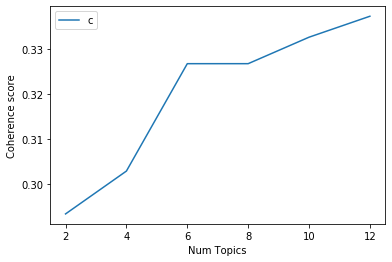

In [14]:
# Show graph

import matplotlib.pyplot as plt

limit=14; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [13]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2933
Num Topics = 4  has Coherence Value of 0.3028
Num Topics = 6  has Coherence Value of 0.3267
Num Topics = 8  has Coherence Value of 0.3267
Num Topics = 10  has Coherence Value of 0.3326
Num Topics = 12  has Coherence Value of 0.3373


# <b>- END HERE BECAUSE RESULT ARE NOT GOOD-<b>

# Coherence Score - dont think need this

In [ ]:
from gensim.models import CoherenceModel

In [ ]:
# Compute Coherence score for lemmatising -tf only
coherence_model_lda_lem = CoherenceModel(model=lda_reviews_lem, texts=doc_lem, dictionary=dict_lem, coherence='c_v')
coherence_lda_lem = coherence_model_lda_lem.get_coherence()
print('\nCoherence Score LDA-lem: ', coherence_lda_lem)


In [ ]:
from pprint import pprint
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

# Most Dominant Topic for each Document

In [ ]:
#Find most dominant topic

import numpy as np
import pandas as pd

def format_topics_sentences(ldamodel, corpus, data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(data)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

#I choose model_list[1] where the number of topics is 4

df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=vec_lem, data=doc_lem)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(100)

# Save Model

In [ ]:
#Save a model to disk, or reload a pre-trained model
import pickle

# lda_lem_tfidf.save("lda")

ldapickle = open('ldapickle', "wb")
pickle.dump(optimal_model, ldapickle)
ldapickle.close()

In [ ]:
import pickle
reader = open("ldamallet_model478927.pickle", "rb")
tester_model = pickle.load(reader)
topics_lem=tester_model.show_topics(10,15)
topics_lem

In [ ]:
# TEST NEW DATA
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from gensim import corpora
import pickle

lemmatizer= WordNetLemmatizer()

stop_list = stopwords.words('english')
stop_list += ['hotel', 'however', 'could', 'get', 'back', 'bit', 'one', 'know', 'i', 'have', 'would', 'take', 'a', 'choose', 'the', 'first', 'second', 'lovely', 'will', 'definitely', 'longer', 'stayed', 'also']

def preprocessing(review):
    sentences = review.split(". ")
    data = [[word.lower() for word in x.split() if word.lower() not in stop_list] for x in sentences]
#     lem = [[lemmatizer.lemmatize(w) for w in doc] for doc in data]
    dict_lem=corpora.Dictionary(data)
    token_to_id2=dict_lem.token2id
    vec_lem= [dict_lem.doc2bow(doc) for doc in data]
    
    return vec_lem

unseen_rev= preprocessing("room and bed is spacious. shower old put room water. staff friendly reception room helpful bar.")

for sen in unseen_rev:
#     tester_model is the lda model that you load with pickle
    result=tester_model[sen]
    result = sorted(result, key=lambda x: x[1], reverse=True)
    topic = result[0][0]
    print(topic)

In [ ]:
import pickle
import nltk

classifier_saved = open("ldamallet_model478927.pickle", "rb") #binary read
tester_model = pickle.load(classifier_saved)
classifier_saved.close()

# TEST NEW DATA
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from gensim import corpora
import pickle

lemmatizer= WordNetLemmatizer()

stop_list = stopwords.words('english')
stop_list += ['hotel', 'however', 'could', 'get', 'back', 'bit', 'one', 'know', 'i', 'have', 'would', 'take', 'a', 'choose', 'the', 'first', 'second', 'lovely', 'will', 'definitely', 'longer', 'stayed', 'also']

def preprocessing(review):
    sentences = review.split(". ")
    data = [[word.lower() for word in x.split() if word.lower() not in stop_list] for x in sentences]
#     lem = [[lemmatizer.lemmatize(w) for w in doc] for doc in data]
    dict_lem=corpora.Dictionary(data)
    token_to_id2=dict_lem.token2id
    vec_lem= [dict_lem.doc2bow(doc) for doc in data]
    
    return vec_lem

unseen_rev= preprocessing("room and bed is spacious. shower old put room water. staff friendly reception room helpful bar.")

gensim_lda = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(tester_model)

# print(unseen_rev)
for sen in unseen_rev:
#     tester_model is the lda model that you load with pickle
    result=gensim_lda[sen]
    result = sorted(result, key=lambda x: x[1], reverse=True)
    topic = result[0][0]
    print(topic)